Add picture*

## Business Understanding

In this project, we are exploring how home sale prices in King County are affected by the different features of the house, such as size, number of bedrooms and bathrooms, location, etc. We have been hired by ABC Realty to build a model that predicts housing prices, to be used by ABC's clients looking to potentially sell their homes. Our goal is to determine how much the seller's home is worth and if there are any improvements/renovations the seller can make to obtain a higher price.

## Data Understanding

### Loading and Investigating the Data

Import necessary libraries for cleaning and plotting data.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

Load the raw dataset and explore the data.

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
# investigate top values for each column.

for col in df.columns:
    print(col)
    print(df[col].value_counts().head())
    print('\n')
        

id
795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64


date
6/23/2014    142
6/26/2014    131
6/25/2014    131
7/8/2014     127
4/27/2015    126
Name: date, dtype: int64


price
350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
Name: price, dtype: int64


bedrooms
3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
Name: bathrooms, dtype: int64


sqft_living
1300    138
1400    135
1440    133
1660    129
1010    129
Name: sqft_living, dtype: int64


sqft_lot
5000    358
6000    290
4000    251
7200    220
7500    119
Name: sqft_lot, dtype: int64


floors
1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
Name: floors, dtype: int64


waterfront
0.0    19075
1.0      146
Name: waterfront, dtype: int64


view
0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Our dataset contains approximately 21,600 rows. There are some missing values that will need to be handled for 'waterfront', 'view', and 'yr_renovated'. In terms of datatypes, date will need to be converted to a date datatype and 'sqft_basement' will need to change to a float datatype.

Price is going to be our dependent variable. Let's look at the distribution of our variables.

### Check Distribution of Variables

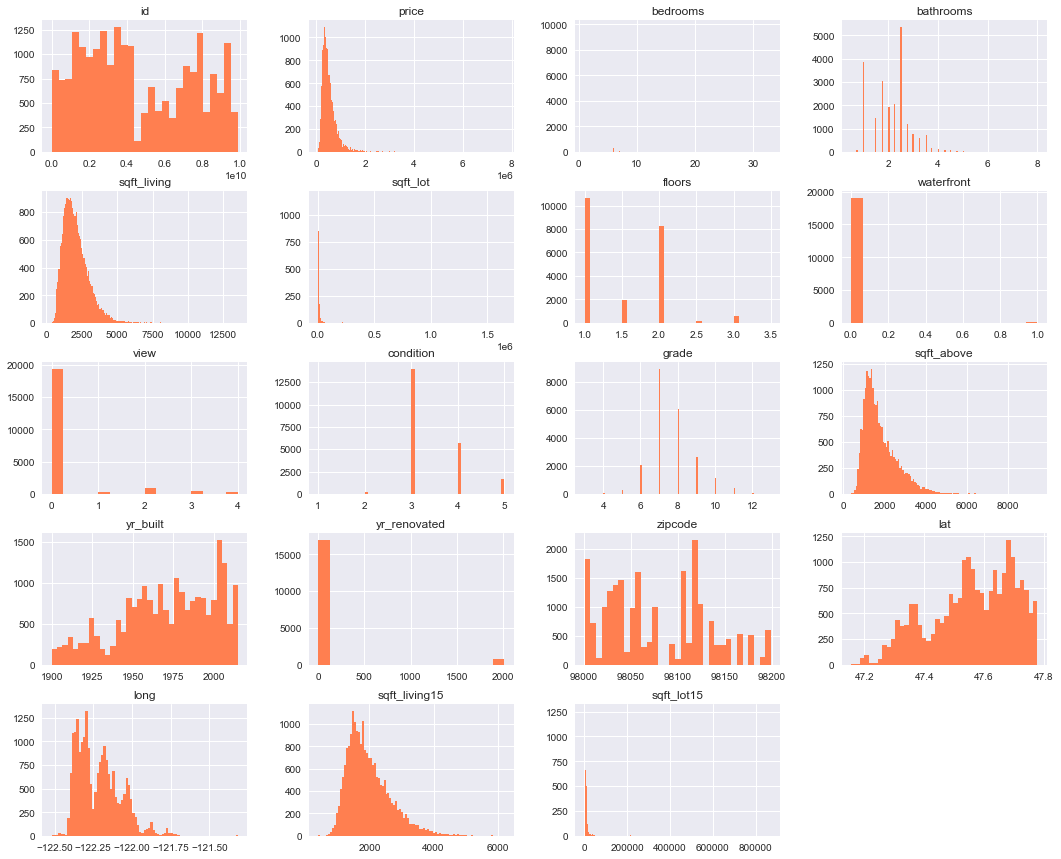

In [6]:
df.hist(figsize=(18,15), bins = 'auto', color='coral');

Some quick observations on our data:

* There are both continuous and categorical variables in our data set. We will need to handle these types of variables separately in order to create the most accurate model.
* There are some outliers in our dependent variable, price, which is skewing our data to the right.
* Bedrooms, sqft lot, and sqft lot 15 also appear to have outliers skewing the data right.
* We also have access to location data through zipcode and also latitude and longitude.

### Visualize Location Data

Next, let's use folium to visualize the actual location of houses we are analyzing.

In [7]:
import folium
king_county = (47.54, -121.98)
king_county_map = folium.Map(location = king_county)

In [50]:
from folium.plugins import HeatMap
HeatMap(data = df.groupby(['zipcode']).median()[['lat', 'long', 'price']].values.tolist()).add_to(king_county_map)
display(king_county_map)

Let's also look at a scatter plot of the data and how price varies by location.

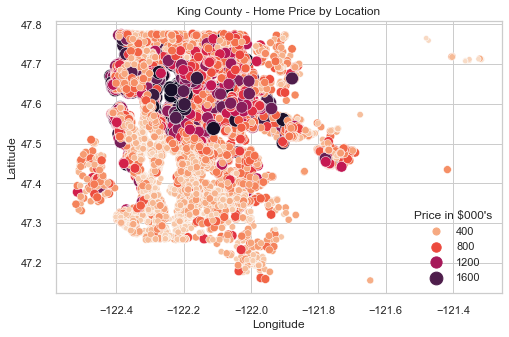

In [71]:
sns.set_style('whitegrid')
df_less_outliers = df[df['price']<2000000]
price_in_thousands = (df_less_outliers.price/1000).rename("Price in $000's")
plt.figure(figsize=(8,5))
ax = sns.scatterplot(data=df, x="long", y="lat", hue=price_in_thousands, palette = "rocket_r", legend="brief", 
                size=price_in_thousands, sizes=(20, 200))
ax.set_title('King County - Home Price by Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude');
plt.savefig("images\price_location.png")

We also have zipcode available to us. It may be helpful to convert the zipcodes into bins to easily see if location has an effect on price.

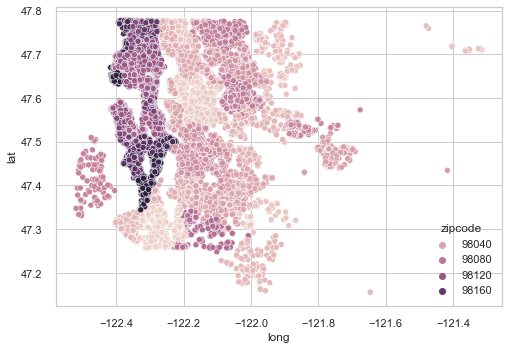

In [76]:
sns.scatterplot(data=df, x="long", y="lat", hue="zipcode", palette = "rocket");

### Check Multicollinearity

Let's check if any of our features are correlated with each other, which could be problematic for our model.

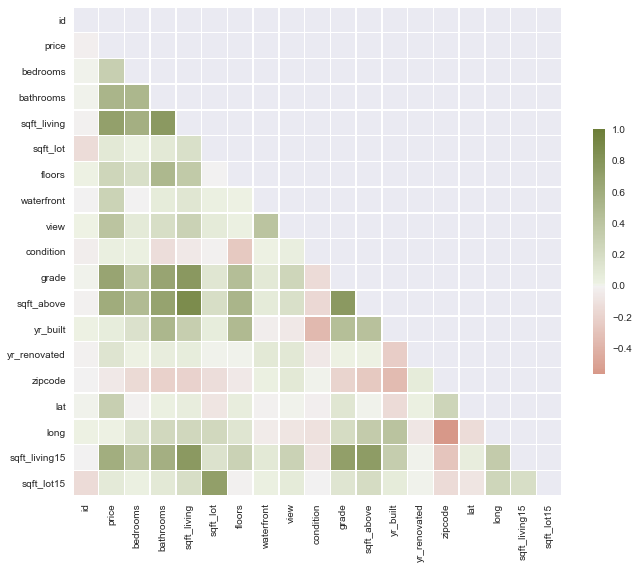

In [11]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 100, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [12]:
df_pairs=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_pairs['pairs'] = list(zip(df_pairs.level_0, df_pairs.level_1))

# set index to pairs
df_pairs.set_index(['pairs'], inplace = True)

#drop level columns
df_pairs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc 
df_pairs.columns = ['cc']

# drop duplicates
df_pairs.drop_duplicates(inplace=True)

In [13]:
# return pairs with high correlation between .75 and 1

df_pairs[(df_pairs.cc>.75) & (df_pairs.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


Based on this, it may make sense to drop sqft_living and sq_ft_above or grade, since these variables are highly correlated with other variables.

### Check Linearity

Lastly, let's check the linearity of each feature by viewing scatter plots.

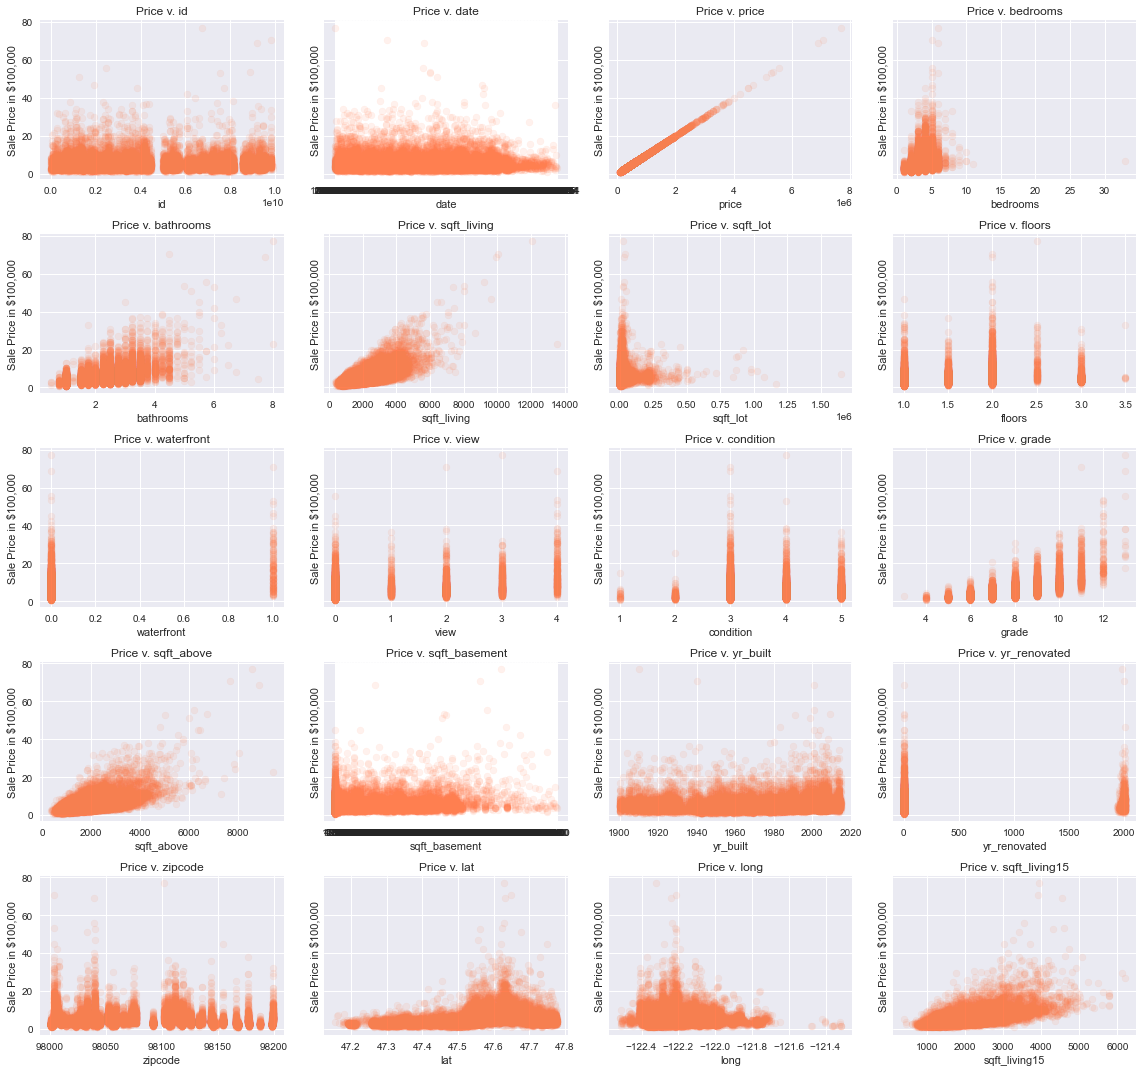

In [14]:
# Your code here 
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), df.columns):
    ax.scatter(df[column], df['price'] / 100000, label=column, alpha=.1, color='coral')
    ax.set_title(f'Price v. {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

Looking at these scatter plots, there may be a linear relationship with price and:
 * bathrooms
 * potentially bedrooms, but will need to take a closer look
 * sqft_living
 * grade
 * sqft_above
 * sqft_living15

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


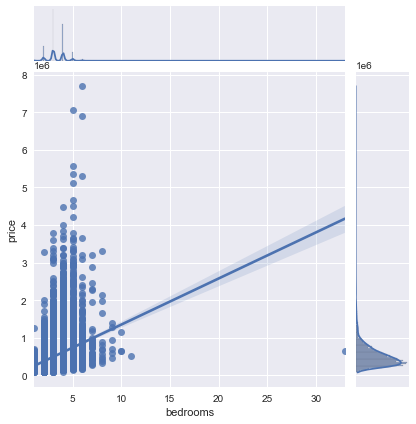

In [15]:
sns.jointplot("bedrooms", "price", data=df, kind="reg")

## Initial Data Preparation

In this section, we will perform basic data cleaning so that the dataset can be properly fed into a baseline model. Additional data cleaning to be performed in the "Housing Data - Modeling" notebook. *ADD LINK HERE

### Converting Datatypes

Let's inspect the sqft_basement values and see if this data type should be changed.

In [16]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1920.0        1
506.0         1
65.0          1
2390.0        1
1930.0        1
Name: sqft_basement, Length: 304, dtype: int64

First, let's convert all '?' values to zero.

In [17]:
df.sqft_basement.replace('?',0.0, inplace=True)

In [18]:
df.sqft_basement.value_counts()

0.0       12826
0.0         454
600.0       217
500.0       209
700.0       208
          ...  
1920.0        1
506.0         1
65.0          1
2390.0        1
1930.0        1
Name: sqft_basement, Length: 304, dtype: int64

Convert datatype to float.

In [19]:
df.sqft_basement = df.sqft_basement.map(lambda x: float(x))

In [20]:
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [21]:
# check that sqft_basement is now a float object.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Next, let's convert the date column to a datetime format.

In [22]:
df['date'] = pd.to_datetime(df['date'])

In [23]:
# Confirm the datatype for date changed.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  float64       
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

### Handling Missing Values

Now, let's inspect and handle the missing values in our data.

In [24]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [25]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,285.716581,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,439.819830,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Looking at the waterfront, view and yr_renovated columns, the median values are 0 for all three columns. We think it is safe to assume these missing values can be filled in with the median values of 0.

In [26]:
for col in df.columns:
    try:
        median = df[col].median()
        df[col] = df[col].fillna(value=median)
    except:
        continue

#recheck missing values and confirm none left.        
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Removing Collinear Columns

Let's remove the collinear features we saw earlier during our multicollinearity check. It looks like sqft_living is correlated with sqft_above, grade, and bathrooms, so let's drop that feature.

In [27]:
df_pairs[(df_pairs.cc>.75) & (df_pairs.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.876448
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


In [28]:
df.drop(['sqft_living', 'grade'], inplace=True, axis=1)

### Further Inspect Bedrooms

<AxesSubplot:>

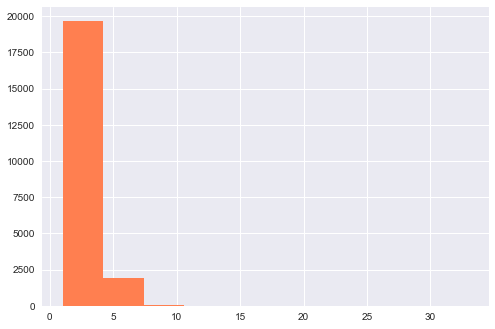

In [29]:
df.bedrooms.hist(color='coral')

In [30]:
df.bedrooms.describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

It appears there is one house with 33 bedrooms that is skewing our bedroom data. Since this is such an extreme outlier, let's go ahead and remove this house from our data set.

In [31]:
df.drop(df[df['bedrooms']==33].index, inplace=True)

<AxesSubplot:>

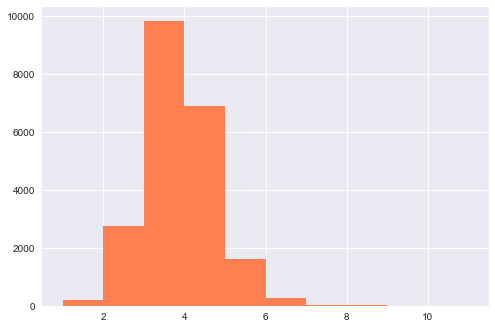

In [32]:
df.bedrooms.hist(color='coral')

C:\Users\saman\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


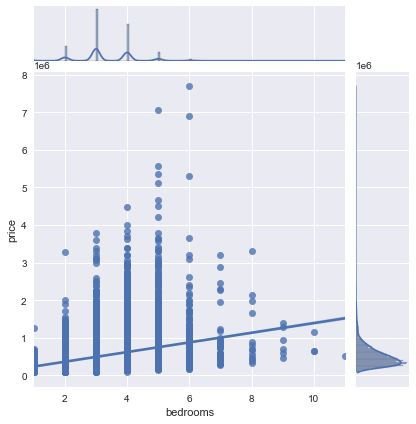

In [33]:
sns.jointplot("bedrooms", "price", data=df, kind="reg");

Our bedroom distribution looks much more normal, which should improve the overall results of our model. The relationship between price and bedrooms also appears to generally be linear.

### Export Clean Data

In [34]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,5650,1.0,0.0,0.0,3,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,7242,2.0,0.0,0.0,3,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,10000,1.0,0.0,0.0,3,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,5000,1.0,0.0,0.0,5,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,8080,1.0,0.0,0.0,3,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [35]:
df.to_csv("data/housing_data_clean.csv", index=False)